# Contents
- [Counter](#Counter)
- [Hamamatsu](#Hamamatsu)
- [Count_Plots](#Count_Plots)
- [Cuts](#Cuts)
- [Loading](#Loading)
- [Retention](#Retention)
- [Copy](#Copy)
- [Settings](#Settings)

In [1]:
%matplotlib notebook

import h5py
import matplotlib.pyplot as plt
from numpy import *
import pandas as pd
import os
import sys
from scipy.optimize import curve_fit
from typing import Dict, Any
import recordclass.recordclass as rc
from itertools import product

if (os.name == 'posix'):
    repo_path = r"/Volumes/C/Public/Users/Hybrid/Repos/Hybrid_H5/H5_python3"
else:
    repo_path = r"C:\Users\Hybrid\Repos\Hybrid_H5\H5_python3"
sys.path.append(repo_path)
# local imports
import HamamatsuH5
import counterh5
from Iterations import Iterations,seed_permute
from PlottingH5 import default_plotting, iterate_plot_2D
from FittingH5 import *

In [2]:
def plt_subplots(nrows=1, ncols=1,*args,**kwargs):
    """
    Function to wrap plt.subplots and make sure the same block of code can plot many axes and a single axis
    """
    fig,axarr = plt.subplots(nrows,ncols,*args,**kwargs)
    if nrows == 1 and ncols == 1:
        axarr = [axarr]
    return fig,axarr
    
h5file = h5py.File('results.hdf5',mode='r+')

iterations = Iterations(h5file)
#Find number of measurements per experiment
measurements = h5file['settings/experiment/measurementsPerIteration'][()]+1
num_its = len(h5file['iterations'])

iterations
#Find independent variable names and values
#indep_vars = DataH5.get_indep_vars(h5file)
#iVars = list(indep_vars.keys())

# map iterations to independent variable values
# iterations = DataH5.make_iterations_df(h5file, iVars)

  iteration
0         0

# Counter

In [16]:
drop_bins = h5file["/iterations/0/variables/RO1_drops"][()]
ro_bins = h5file["/iterations/0/variables/RO1_bins"][()]
shots_per_measurement = int(h5file['/settings/experiment/LabView/camera/shotsPerMeasurement/function'][()])
counter_bin, counter_shot = counterh5.load_data(h5file, drop_bins, ro_bins)
count_data = counter_shot

## Plot data bins as bar graphs

<IPython.core.display.Javascript object>


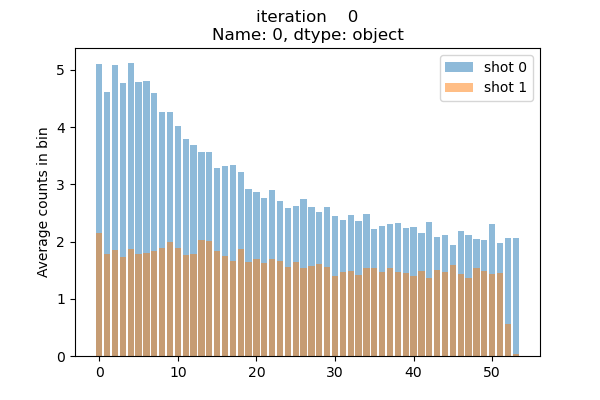

In [13]:
plots = True
if plots and len(iterations) > 22:
    ans = input(f"You're about to plot {len(iterations)} bin bar graphs. Are you sure you want to do that? (y/N) : ").upper()[0]
    plots = ans=="Y"
if plots:
    fig,axarr = plt_subplots(len(iterations),1,figsize=(6,4*len(iterations)))
    for iteration, row in iterations.iterrows():
        iteration = int(iteration)
        # bin shot 0 and shot 1 the same way
        for shot in range(shots_per_measurement):
            axarr[iteration].bar(range(ro_bins),counter_bin.mean(1)[iteration,shot,drop_bins:],alpha=0.5,label = f"shot {shot}")
        axarr[iteration].set_ylabel("Average counts in bin")
        axarr[iteration].legend()
        axarr[iteration].set_title(str(row))
    fig.show()

To analyze count data go to:
- [Count_Plots](#Count_Plots)

# Hamamatsu

In [3]:
# Set ROI
fg = HamamatsuH5.set_frame_grabber_region(h5file)
width = fg['right']-fg['left']
height = fg['bottom']-fg['top']

# For documentation try > help(HMROI)
roi = HamamatsuH5.HMROI(width,height,dic = {
    "left" : 1,
    "right" : 4,
    "top" : 4,
    "bottom" : 7
})
#roi = HamamatsuH5.HMROI(width,height)

#Load data into memory
shots_per_measurement = int(h5file['/settings/experiment/LabView/camera/shotsPerMeasurement/function'][()])
# pixel-by-pixel data indexed : [iteration, measurement, shot, y-pixel, x-pixel]
hm_pix = HamamatsuH5.load_data(h5file,roi)

#take pixel-by-pixel data and treat it into counter data then mean data
# "count" data indexed : [iteration, measurement, shot]
hm_counts = hm_pix.sum(3).sum(3)
# mean count data indexed : [iteration, shot]
mus = hm_counts.mean(1)
# standard deviation in mean indexed : [iteration, shot]
ers = hm_counts.std(1)/sqrt(measurements)

count_data = hm_counts

## Show images taken within ROI

In [ ]:
## show average image for one shot for each iteration
im_shot = 0 # shot to image

fig,axarr = plt_subplots(len(iterations),1,figsize=(6,4*len(iterations)))
for index, row in iterations.iterrows():
    iteration = row['iteration']
    axarr[iteration].imshow(hm_pix[iteration,:,im_shot,:,:].mean(0))
    axarr[iteration].set_title(str(row))
fig.tight_layout()
fig.show()

## Plot Histogram data of each pixel for each iteration
* Very memory hungry!
* Please clear output before saving, copying or pushing if this cell was run

In [ ]:
im_width = roi.right-roi.left
im_height = roi.bottom-roi.top
for iteration, row in iterations.iterrows():
    i = row['iteration']
    fig,axarr = plt.subplots(im_height,im_width,figsize = (10,10))
    for y in range(im_height):
        for x in range(im_width):
            bns = 20
            for shot in range(shots_per_measurement):
                axarr[y,x].hist(hm_pix[i,:,shot,y,x],bins=bns,histtype='step',label = f"Shot {shot}")
            axarr[y,x].set_title(f"x = {x}, y = {y}")
            axarr[y,x].legend()
    fig.suptitle(str(row))
    fig.tight_layout()
    fig.show()

# Count_Plots
Plot count data from some instrument (could be Hamamatsu, counter or other single-photon sensitive instrument)

## Plot Histograms of count data

<IPython.core.display.Javascript object>


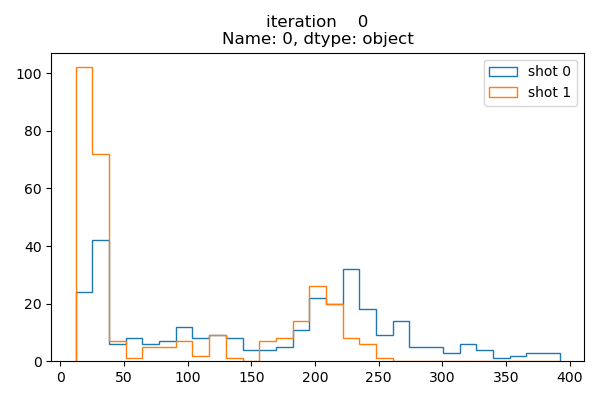

In [20]:
plots = True
if plots and len(iterations) > 22:
    ans = input(f"You're about to plot {len(iterations)} histograms. Are you sure you want to do that? (y/N) : ").upper()[0]
    plots = ans=="Y"
if plots:
    n_bins = 30
    fig,axarr = plt_subplots(len(iterations),1,figsize=(6,4*len(iterations)))
    for iteration, row in iterations.iterrows():
        iteration = int(iteration)
        # bin shot 0 and shot 1 the same way
        bns = linspace(count_data[iteration,:,:].min(), count_data[iteration,:,:].max(), n_bins)
        # bin shot 0 and shot 1 differently
        # bns = n_bins
        for shot in range(shots_per_measurement):
            axarr[iteration].hist(count_data[iteration,:,shot],histtype='step', label = f"shot {shot}",bins=bns)
        axarr[iteration].legend()
        axarr[iteration].set_title(str(row))
        fig.tight_layout()
    fig.show()
else:
    print("You have chosen not to plot the histograms.")

## Plot mean count data
* If only 1 iteration : Prints out means for each shot and the corresponding standard deviation
* If there is 1 independent variable : Plot means for each iteration with error bars
* If there are 2 independent variables : show image of means for each iteration.

In [18]:
default_plotting(iterations,count_data.mean(1),count_data.std(1),shots_per_measurement,description="Mean Counts in ROI")

shot 0 Mean Counts in ROI : 162.22591362126246 +/- 100.14684629832757
shot 1 Mean Counts in ROI : 85.98006644518273 +/- 80.78045141139125


## 2D as many 1D

* Often, when a 2D scan is performed it's more enlightening to plot each row (or column) of data as a line graph

In [19]:
iterate_plot_2D(**{
    "iterations": iterations,
    "data": count_data.mean(1),
    "data_error": count_data.std(1),
    "description": "Counts in ROI",
})

ValueError: This plot only works to plot data from an experiment with two independent variables

# Cuts

In [ ]:
# Utility and calibration functions to be moved to files

def fit_and_plot_hist(func,counter_data,bns,guess,title="",plots=True):
    
    hist, bin_edges = histogram(counter_data,bins=bns)
    mids = (bin_edges[0:-1] + bin_edges[1:])/2
    try:
        popt,pcov = curve_fit(f=func,xdata=mids,ydata=hist,p0 = guess)
    except RuntimeError as e:
        print(f"Unable to fit\n{e}")
        popt = array(guess)
        pcov = zeros((len(popt),len(popt)))
        bad_fit = True
    else:
        bad_fit = False
    perr = sqrt(diag(pcov))
    
    if plots:
        fig,ax = plt.subplots(1,1,figsize=(8,6))
        xlin = linspace(min(counter_data),max(counter_data),1000)
        ax.hist(counter_data,bins=bns,histtype='step',label="Raw Data")
        label = "Guess" if bad_fit else "Fit"
        ax.plot(xlin,func(xlin,*popt),label=label)
        ax.set_title(title.format(popt,perr))
        ax.legend()
        fig.tight_layout()
        fig.show()
    else:
        fig, ax = (None, None)
    return popt, pcov, perr, fig, ax

def hamamatsu_count_calibration(counter_data,offset,EM_gain, analog_gain):
    """
    converts hamamatsu counting data to number of incident photons
    Args:
        counter_data : ndarray of camera counts
        offset : couning offset
        EM_gain : EM gain setting on the camera
        analog_gain : analog gain setting on the camera
    """
    return (counter_data - offset) / (EM_gain * analog_gain)

def hamamatsu_inv_calibration(counter_data, offset, EM_gain, analog_gain):
    """
    converts photon counting data to haamamtsu camera count data. 
    
    Inverse function of hamamatsu_count_calibration
    Args:
        counter_data : ndarray of camera counts
        offset : couning offset
        EM_gain : EM gain setting on the camera
        analog_gain : analog gain setting on the camera
    """
    return (counter_data * EM_gain * analog_gain) + offset

def expand_iter_array(iterations,iter_array,no_measurements,no_shots):
    """
    Expands an array of len() == len(iterations) to an ndarray of the shape of shot-by-shot data.
    
    An iter array is an array of shape = (len(iteration),), and is indexed [iteration].
        The assumption being that it's an array containing iteration-by-iteration data.
    An array with shot-by-shot data is indexed [iteration,measurement,shot]
    """
    if len(iter_array) != len(iterations):
        raise ValueError("Iter arrays must have length of iterations")
    fixed_array = ones((len(iterations),no_measurements,no_shots))
    for i, row in iterations.iterrows():
        iteration = row['iteration']
        fixed_array[iteration] = iter_array[iteration]*fixed_array[iteration]
    return fixed_array

In [ ]:
offset = 20940
EM_gain = 500
analog_gain = 1
count_data = hamamatsu_count_calibration(hm_counts, offset, EM_gain, analog_gain)
shot_to_fit = 0

plots = True

fit_to = "Poisson"
if fit_to == "Poisson":
    func = double_poisson
    get_cut = poisson_intercept
    get_cut_err = cut_err_poisson
    get_overlap = poisson_discrimination_error
    guess = {
        "mu1": 5,
        "mu2": 20.0,
        "a1": 2000,
        "a2": 5000
    }
elif fit_to == "Gauss":
    func = double_gaussian
    get_cut = gauss_cut
    get_cut_err = cut_err_gauss
    get_overlap = gauss_discrimination_error
    guess = {
        "mu1": 21000,
        "mu2": 26000,
        "std1": 500,
        "std2": 4000,
        "a1": 20000,
        "a2": 50000
    }
else:
    raise ValueError(f"fit_to must be either 'Poisson' or 'Gauss'. Not {fit_to}")

    
cuts = zeros(len(iterations))
multi_cuts = zeros(len(iterations))
cut_errs = zeros(len(iterations))
overlaps = zeros(len(iterations))

for i, row in iterations.iterrows():
    iteration = row['iteration']
    bns = 25
    title = "mu1 : {0[0]:.2f} $\pm$ {1[0]:.3f} | mu2 : {0[1]:.2f} $\pm$ {1[1]:.3f}"
    popt, pcov, perr, fig, ax = fit_and_plot_hist(
        func,
        count_data[iteration,:,shot_to_fit],
        bns,
        list(guess.values()),
        title,
        plots
    )
        
    
    popt = abs(popt)
    # If our mus are switched, we switch parameters by hand
    if popt[0] > popt[1]:
        pk1 = copy(popt[0::2])
        dpk1 = copy(perr[0::2])
        popt[0::2] = popt[1::2]
        perr[0::2] = perr[1::2]
        popt[1::2] = pk1
        perr[1::2] = dpk1
    
    try:
        cut = get_cut(*popt)
        cut_err = get_cut_err(*append(popt,perr))
        ovlp = get_overlap(cut,*popt)
    except ValueError as e:
        print(e)
        cut = popt[0]
        cut_err = 0
        ovlp = 0
        intercepts = list(gauss_intercepts(*popt))
        print(f"intercepts = {intercepts[0:2]}\na, b, c = {intercepts[2:]}")
    
    cuts[iteration] = cut
    cut_errs[iteration] = cut_err
    overlaps[iteration] = ovlp
    if fit_to == "Poisson":
        std2 = sqrt(popt[1])
    else:
        std2 = popt[3]
    multi_cuts[iteration] = popt[1]+std2*2.5  # Cut off the multi-atoms at three standard deviations
    
    if plots:
        title = title.format(popt,perr) + f"\ncut = {cut:.2f} +\- {cut_err:.3f}\noverlap = {ovlp:.3f}"
        ax.axvline(cut,label = 'cut')
        ax.axvline(cut-cut_err)
        ax.axvline(cut+cut_err)
        ax.legend()
        ax.set_title(title)
        fig.tight_layout()
        fig.show()
    
    print(f"Overlap : {ovlp}")
    print(f"Cut : {cut} +\- {cut_err}")
    print(f"popt : {popt}\nperr : {perr}\npcov : {pcov}")
    
cuts = hamamatsu_inv_calibration(cuts, offset, EM_gain, analog_gain)
cut_errs = hamamatsu_inv_calibration(cut_errs, offset, EM_gain, analog_gain) - offset
multi_cuts = hamamatsu_inv_calibration(multi_cuts, offset, EM_gain, analog_gain)

default_plotting(iterations,cuts,cut_errs,1,"Optimal Cut")
default_plotting(iterations,overlaps,shots=1,description="Classification Error Rate")

# Loading

<IPython.core.display.Javascript object>


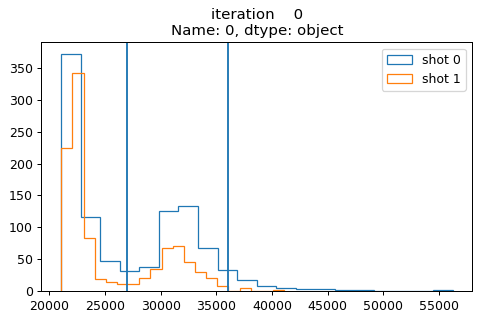

shot 0 Zero atom loading : 0.5474525474525475 +/- 0.015732156717541256
shot 1 Zero atom loading : 0.6893106893106893 +/- 0.01462694484153524
shot 0 Single atom loading : 0.40159840159840154 +/- 0.01549441991116889
shot 1 Single atom loading : 0.3046953046953047 +/- 0.014548004384120171
shot 0 Multi atom loading : 0.05094905094905095 +/- 0.006950175552906972
shot 1 Multi atom loading : 0.005994005994005994 +/- 0.002439697883015318
shot 0 Multi_to_Single atom loading : 0.12686567164179108 +/- 0.016981813466171766
shot 1 Multi_to_Single atom loading : 0.019672131147540982 +/- 0.014751154440272434


In [8]:
shots = 2

hists = True  # Display histograms of loading dataq
fit_cuts = False  # Use cuts derived from fits? If not uses cut specified bellow
# Set count data variable, so this works regadless of device
count_data = hm_counts
cut = 27000  # 0 atom - 1 atom cut
multi_cut = 36000  # 1 atom - multi atom cut

if fit_cuts:
    exp_cuts = expand_iter_array(iterations,cuts,measurements,shots_per_measurement)
    exp_cut_errs = expand_iter_array(iterations,cut_errs,measurements,shots_per_measurement).mean(1)
    exp_multi_cuts = expand_iter_array(iterations,multi_cuts,measurements,shots_per_measurement)
    exp_overlaps = expand_iter_array(iterations,overlaps,measurements,shots_per_measurement).mean(1)
    
    zero_loading = (count_data < exp_cuts).sum(1)/measurements
    zero_loading_error_bar = sqrt(shot_error(zero_loading, measurements)**2+exp_overlaps**2)
    multi_loading = (count_data > exp_multi_cuts).sum(1)/measurements
    multi_loading_error_bar = shot_error(multi_loading, measurements)
    single_loading = 1-(zero_loading+multi_loading)
    single_loading_error_bar = sqrt(shot_error(single_loading, measurements)**2+exp_overlaps**2)
    multi_to_single_loading = multi_loading/single_loading
    multi_to_single_loading_error_bar = sqrt(multi_loading_error_bar**2 + single_loading_error_bar**2)
else:
    zero_loading = (count_data < cut).sum(1)/measurements
    zero_loading_error_bar = shot_error(zero_loading, measurements)
    multi_loading = (count_data > multi_cut).sum(1)/measurements
    multi_loading_error_bar = shot_error(multi_loading, measurements)
    single_loading = 1-(zero_loading+multi_loading)
    single_loading_error_bar = shot_error(single_loading, measurements)
    multi_to_single_loading = multi_loading/single_loading
    multi_to_single_loading_error_bar = sqrt(multi_loading_error_bar**2 + single_loading_error_bar**2)
    
loadings = {
    0: "Zero",
    1: "Single",
    2: "Multi",
    3: "Multi_to_Single"
}

if hists and len(iterations) > 22:
    ans = input(f"You're about to plot {len(iterations)} histograms. Are you sure you want to do that? (y/N) : ").upper()[0]
    hists = ans=="Y"
    
if hists:
    fig,axarr = plt_subplots(len(iterations),1,figsize=(6,4*len(iterations)))
    for iteration, row in iterations.iterrows():
        iteration = int(iteration)
        for shot in range(shots_per_measurement):
            axarr[iteration].hist(hm_counts[iteration,:,shot],histtype='step', label = f"shot {shot}",bins=20)
        axarr[iteration].legend()
        if fit_cuts:
            cut = cuts[iteration]
            multi_cut = multi_cuts[iteration]
            axarr[iteration].axvline(cut+cut_errs[iteration])
            axarr[iteration].axvline(cut-cut_errs[iteration])
        axarr[iteration].axvline(cut)
        axarr[iteration].axvline(multi_cut)
        axarr[iteration].set_title(str(row))
        fig.tight_layout()
    fig.show()
else:
    print("You have chosen not to plot the histograms.")
for num,name in loadings.items():
    rate = eval(f"{name.lower()}_loading")
    rate_error_bar = eval(f"{name.lower()}_loading_error_bar")
    default_plotting(iterations,rate,rate_error_bar,shots=shots,description = f"{name} atom loading")

# Retention

In [9]:
shots = 2

# Set count data variable, so this works regadless of device
count_data = hm_counts

# Use cuts derived from fitting in "Cuts" cell? If False hardcoded cut bellow will be used
fit_cuts = False 

cut = 26000  # 0 atom - 1 atom cut
multi_cut = 36000  # 1 atom - multi atom cut

if fit_cuts:
    exp_cuts = expand_iter_array(iterations,cuts,measurements,shots_per_measurement)
    exp_cut_errs = expand_iter_array(iterations,cut_errs,measurements,shots_per_measurement).mean(1)
    exp_multi_cuts = expand_iter_array(iterations,multi_cuts,measurements,shots_per_measurement)
    exp_overlaps = expand_iter_array(iterations,overlaps,measurements,shots_per_measurement).mean(1).mean(1)
    
    single_loading = (count_data < exp_multi_cuts)*(count_data > exp_cuts) # Measurements that were loaded
else:
    single_loading = (count_data < multi_cut)*(count_data > cut)  # Measurements that were loaded
    exp_overlaps = 0  # Hardcode classification error rate here

retained = single_loading[...,1]*single_loading[...,0]  # Measurements that were retained
loaded = single_loading[...,0].sum(1)  # Number of loaded measurements in each iteration

retention = retained.sum(1)/loaded
retention_error_bar = sqrt(shot_error(retention,loaded)**2+exp_overlaps**2)

default_plotting(iterations,retention,retention_error_bar,description = "Retention")

shot 0 Retention : 0.6580188679245284 +/- 0.023037604481271408


In [ ]:
print(exp_overlaps)
print(shot_error(retention,loaded))

# Copy

In [ ]:
# Copy to next results folder

import datetime
import shutil
import re
import os
import operator
from numpy import sort

volume = os.getcwd()[0]
analysis_fname = 'Analysis3.ipynb'
measurement_path = os.path.dirname(os.path.dirname(os.getcwd()))
dir_filter = lambda f : os.path.isdir(f)

# If the latest experiment folder already has an analysis file, should that be overwritten?
override = True

# find latest day folder created by cspy
daily_folders = list(filter(
    dir_filter,
    [os.path.join(measurement_path,f) for f in os.listdir(measurement_path)]
))  # make sure non-folder names are not listed
today_path = sort(daily_folders)[-1]
print(today_path)
#find all experiments taken on the last day
experiments_today = list(filter(
    dir_filter,
    [os.path.join(today_path,f) for f in os.listdir(today_path)]
))
#and the last experiment taken the last day
last_experiment = sort(experiments_today)[-1]
exp_path = os.path.join(today_path, last_experiment)

# Copy
if analysis_fname not in os.listdir(exp_path) or override:
    print("Copying {} from :\n\t{}\nto:\n\t{}".format(analysis_fname,os.getcwd(),exp_path))
    shutil.copy(os.path.join(os.getcwd(),analysis_fname),exp_path)
else:
    print("Folder {} already have analysis file. If you wish to overwrite that file set 'override' to True".format(exp_path))

In [2]:
# Copy to Git Repo

import datetime
import shutil
import re
import os
import operator
from numpy import sort

if (os.name == 'posix'):
    repo_path = r"/Volumes/C/Public/Users/Hybrid/Repos/Hybrid_H5/H5_python3"
else:
    repo_path = r"C:\Users\Hybrid\Repos\Hybrid_H5\H5_python3"

volume = os.getcwd()[0]
analysis_fname = 'Analysis3.ipynb'
measurement_path = os.path.dirname(os.path.dirname(os.getcwd()))
dir_filter = lambda f : os.path.isdir(f)

# If the latest experiment folder already has an analysis file, should that be overwritten?
override = True

# Copy
if analysis_fname not in os.listdir(repo_path) or override:
    print(f"Copying {analysis_fname} from :\n\t{os.getcwd()}\nto:\n\t{repo_path}")
    shutil.copy(os.path.join(os.getcwd(),analysis_fname),repo_path)
else:
    print(f"Folder {repo_path} already have analysis file. If you wish to overwrite that file set 'override' to True")

Copying Analysis3.ipynb from :
	E:\Data\Measurements\2020_12_08\2020_12_08_17_57_42_BL
to:
	C:\Users\Hybrid\Repos\Hybrid_H5\H5_python3


# Settings

In [ ]:
for name,group in h5file['settings/experiment/independentVariables/'].items():
    print(f"{name} : \t\t {group['function'][()]}")

# TODO:
- Make array of iteration-by-iteration classification errors from Cuts cells.
    - Specifically, adding classification errors due to function overlaps and cut_uncertainty, in quadrature
- Compartmentalize parts of Cuts cells for ease of use
- Move Utility and Calibration functions to files
- Make functions inside files for general discrimination
- Load info like Cut values, Camera calibrations etc into variables or class attributes to be used throughout notebook